# Applicability Domain Workflow

### Introduction

Workflow for estimation of Applicability Domain (AD) based on Euclidean distances. 

The AD of a QSAR model must be defined to flag compounds in the test set for which predictions may be unreliable. In this workflow, similarity measurements are used to define the AD of the model based on the Euclidean distances among all the compounds of the training set. Then, we estimate if compounds of the test are inside the AD of the training set. The distance of a test compound to its nearest neighbor in the training set is compared to the calculated AD Threshold (ADT) of the training set. If the similarity is beyond this threshold, the prediction is considered unreliable.

ADT is calculated as follows: 

ADT = D + Zσ 

where where Z is a similarity threshold parameter defined by the user (default is 0.5), and D and σ are the average and standard deviation, respectively, of all Euclidian distances in the multidimensional descriptor space between each compound and its nearest neighbors for all compounds in the training set.

This method has been defined by A. Golbraikh, M. Shen, Z. Xiao, Y.-D. Xiao, K.-H. Lee, A. Tropsha. J. Comput. Aided. Mol. Des. 2003, 17 (2–4), 241–253.

In [1]:
import pandas as pd
import numpy as np
from rdkit.Chem import PandasTools
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from sklearn.model_selection import train_test_split
from scipy.spatial import distance_matrix

### ADT function

In [2]:
def calc_training_dist_matrix(training_descriptors):
    """Calculate the distance of every compound in the training set
    from every other compound in the training set."""
    return np.sort(distance_matrix(training_descriptors,training_descriptors),axis=1)[:,1:]

def calc_d_cutoff(distance_matrix, user_cutoff=0.5):
    """Calculate the cutoff value defining the applicability domain
    for the entire training set."""
    average_dist = np.mean(distance_matrix, axis=None)
    std_dev = np.std(distance_matrix, axis=None)
    return (average_dist + user_cutoff * std_dev)

def calc_test_distances(testing_descriptors,training_descriptors):
    """Calculate distance of each compound in the test set
    from every compound in the training set"""
    return distance_matrix(testing_descriptors,training_descriptors)

def test_AD(test_value,threshold):
    """Return boolean value for compound; 1 if compound in AD, 0 if not."""
    if test_value < threshold:
        return 1
    return 0

def percent_reliable(test_df):
    """Return the portion of compounds in the test set that have been calculated to be reliable."""
    count_reliable = len(test_df[test_df.Applicability_Domain == "Reliable"])
    return count_reliable/len(test_df)

### Import curated datasets

In [3]:
train = PandasTools.LoadSDF('training_set.sdf')
train.head(1)

FileNotFoundError: [Errno 2] No such file or directory: 'training_set.sdf'

,Activity,ID,MOL,Outcome,ROMol,Set
0,-0.16,,es1_1,Inactive,,es1

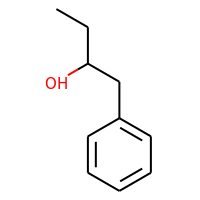

In [4]:
test = PandasTools.LoadSDF('test_set.sdf')
test.head(1)

### Calculate descriptors

In [5]:
# Training set
def calcfp(mol,funcFPInfo=dict(radius=3, nBits=2048, useFeatures=False, useChirality = False)):
    fp = GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    fp = pd.Series(np.asarray(fp))
    fp = fp.add_prefix('bit_')
    return fp

morgan_train = train.ROMol.apply(calcfp)
morgan_train.shape

(644, 2048)

In [6]:
# Test set
morgan_test = test.ROMol.apply(calcfp)
morgan_test.shape

(449, 2048)

### Prepare data for modeling


In [7]:
y_train = train['Activity']
X_train = morgan_train

y_test = test['Activity']
X_test = morgan_test

### Estimate the ADT of the model

In [8]:
distances = calc_training_dist_matrix(X_train)

In [9]:
D_cutoff = calc_d_cutoff(distances)
print(D_cutoff)

6.2278283338925755


### Calculate if moleles in the test set are in the AD of the model

In [10]:
test_set_distances = calc_test_distances(X_test,X_train)

In [11]:
test_values = np.apply_along_axis(calc_d_cutoff,1,test_set_distances)

In [12]:
test_values.shape

(449,)

In [13]:
v_test_AD = np.vectorize(test_AD)
test_AD_results = v_test_AD(test_values,D_cutoff)

In [14]:
test['Applicability_Domain'] = test_AD_results
test['Applicability_Domain'] = test.Applicability_Domain.map(lambda x: "Reliable" if x else "Unreliable")

,Activity,ID,MOL,Outcome,ROMol,Set,Applicability_Domain
0,-0.16,,es1_1,Inactive,,es1,Unreliable

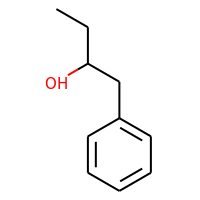

In [15]:
test.head(1)

In [16]:
coverage = percent_reliable(test)
print(coverage)

0.44766146993318484
